## PFDA Project - Contact Center Performance Analysis

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data & Set Index
df = pd.read_excel('pwc_call_centre_data.xlsx')
df.set_index('Date', inplace=True)
df.head()

,Call Id,Agent,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
Date,,,,,,,,,
2021-01-01,ID0001,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
2021-01-01,ID0002,Becky,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2021-01-01,ID0003,Stewart,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
2021-01-01,ID0004,Greg,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
2021-01-01,ID0005,Becky,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0


In [4]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()


## Section 1 - Data Cleaning

To analyse the data efficiently and see if there is a correlation between speed of answer in seconds and AvgTalkDuration they most both be in seconds. Pandas documentation shows how to convert minutes into seconds https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.total_seconds.html

Besides AverageTalkDuration the other data types are in order so no more adjustments to be made.

In [5]:
# Ensure 'AvgTalkDuration' is in string format
df['avgtalkduration'] = df['avgtalkduration'].astype(str)

# Convert 'AvgTalkDuration' to seconds
df['avgtalkduration_seconds'] = pd.to_timedelta(df['avgtalkduration']).dt.total_seconds()


There are three columns with 946 null values each. When running df.head(50) there is a clear trend where the null values are coming from, when the call isn't answered. Neither dropna() or fillna() would be benificial for analysis so null values are being kept as is.

In [6]:
# Check are there null values to deal with
df.isnull().sum()

call id                         0
agent                           0
time                            0
topic                           0
answered (y/n)                  0
resolved                        0
speed of answer in seconds    946
avgtalkduration                 0
satisfaction rating           946
avgtalkduration_seconds       946
dtype: int64

In [7]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [8]:
# Drop Irrelevant Columns
df = df.drop(columns=['call id'])
df.head()

,agent,time,topic,answered (y/n),resolved,speed of answer in seconds,avgtalkduration,satisfaction rating,avgtalkduration_seconds
Date,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0,143.0
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0,242.0
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0,131.0
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0,37.0
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0,60.0


Before starting my analysis I added some additional columns that will be used in later sections. I defined functions containing IF, ELIF and ELSE statements to determine which category they fall into.

In [9]:
# Ensure in datetime format
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Define a function to categorise the time
def categorise_time(time):
    if time >= pd.to_datetime('05:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('17:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('17:00:00').time() and time < pd.to_datetime('21:00:00').time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['time_of_day_category'] = df['time'].apply(categorise_time)

df.head(1)

,agent,time,topic,answered (y/n),resolved,speed of answer in seconds,avgtalkduration,satisfaction rating,avgtalkduration_seconds,time_of_day_category
Date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0,143.0,Morning


In [10]:
df['avgtalkduration_seconds'].describe()

count    4054.000000
mean      224.922792
std       111.381555
min        30.000000
25%       130.000000
50%       226.000000
75%       319.000000
max       420.000000
Name: avgtalkduration_seconds, dtype: float64

## Section 2 - EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2021-01-01 to 2021-03-31
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   agent                       5000 non-null   object 
 1   time                        5000 non-null   object 
 2   topic                       5000 non-null   object 
 3   answered (y/n)              5000 non-null   object 
 4   resolved                    5000 non-null   object 
 5   speed of answer in seconds  4054 non-null   float64
 6   avgtalkduration             5000 non-null   object 
 7   satisfaction rating         4054 non-null   float64
 8   avgtalkduration_seconds     4054 non-null   float64
 9   time_of_day_category        5000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 429.7+ KB


In [12]:
df.describe()

,speed of answer in seconds,satisfaction rating,avgtalkduration_seconds
count,4054.000000,4054.000000,4054.000000
mean,67.520720,3.403552,224.922792
std,33.592872,1.212220,111.381555
min,10.000000,1.000000,30.000000
25%,39.000000,3.000000,130.000000
50%,68.000000,3.000000,226.000000
75%,97.000000,4.000000,319.000000
max,125.000000,5.000000,420.000000


In [13]:
# Compute the correlation matrix 
columns_to_correlate = ['speed of answer in seconds','avgtalkduration_seconds', 'satisfaction rating']
correlation_matrix = df[columns_to_correlate].corr()
correlation_matrix

,speed of answer in seconds,avgtalkduration_seconds,satisfaction rating
speed of answer in seconds,1.000000,-0.002898,0.000952
avgtalkduration_seconds,-0.002898,1.000000,0.000143
satisfaction rating,0.000952,0.000143,1.000000


## Business Insights - Resolution Rate, Unanswered Calls & Customer Satisfaction
For a contact centre the first area of the dataset to analyse is their resolution rate. PWCs resolution rate is currently 73% which is positive but there is definitely some room for improvement. There are two pieces of code below, the first is calculating the resolution % and the other provides a visual.

For this visual I wanted to add the counts of "Y" and "N" in the "resolved" column. I figured out how to do this through matplotlib documentation. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html

Syntax breakdown for ax.bar_label(bars, fmt='%g', fontsize=10) : "bars" refers to the bar charts created when executing ax.bar(), "fmt='g'" formats the string for a label and "fontsize" is self-explanatory.



In [14]:
# Calculate total issues
total_issues = df['resolved'].count()

# Count resolved issues
resolved_issues = (df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")


'Percentage of resolved issues: 73%'

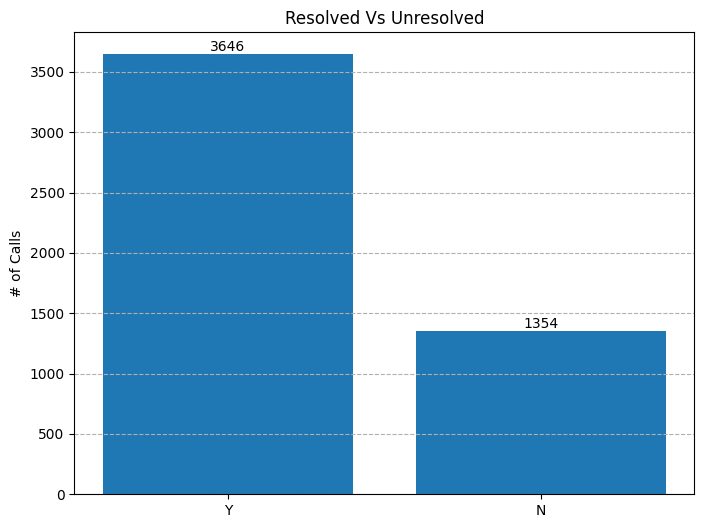

In [15]:
counts = df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

In [33]:
# Calculate resolution rates by topic
resolution_by_topic = df.groupby('topic')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Calculate resolution rates by agent
resolution_by_agent = df.groupby('agent')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Calculate resolution rates by time of day
resolution_by_time = df.groupby('time_of_day_category')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Display insights
print("Resolution Rate by Topic:\n", resolution_by_topic)
print("\nResolution Rate by Agent:\n", resolution_by_agent)
print("\nResolution Rate by Time of Day:\n", resolution_by_time)


Resolution Rate by Topic:
 topic
Admin Support        74.1
Contract related     72.6
Payment related      72.4
Streaming            73.3
Technical Support    72.2
Name: resolved, dtype: float64

Resolution Rate by Agent:
 agent
Becky      73.2
Dan        74.4
Diane      71.4
Greg       72.9
Jim        72.8
Joe        73.5
Martha     72.3
Stewart    72.9
Name: resolved, dtype: float64

Resolution Rate by Time of Day:
 time_of_day_category
Afternoon    72.5
Evening      73.0
Morning      73.6
Name: resolved, dtype: float64


In [37]:
# Unanswered call rate by agent
unanswered_by_agent = df[df['answered (y/n)'] == 'N'].groupby('agent').size()

# Unanswered call rate by time of day
unanswered_by_time = df[df['answered (y/n)'] == 'N'].groupby('time_of_day_category').size()

# Display insights
print("Unanswered Calls by Agent:\n", unanswered_by_agent)
print("\nUnanswered Calls by Time of Day:\n", unanswered_by_time)


Unanswered Calls by Agent:
 agent
Becky      114
Dan        110
Diane      132
Greg       122
Jim        130
Joe        109
Martha     124
Stewart    105
dtype: int64

Unanswered Calls by Time of Day:
 time_of_day_category
Afternoon    519
Evening      110
Morning      317
dtype: int64


In [35]:
# Satisfaction by resolution status
satisfaction_by_resolution = df.groupby('resolved')['satisfaction rating'].mean()

# Satisfaction by topic
satisfaction_by_topic = df.groupby('topic')['satisfaction rating'].mean()

# Satisfaction by call duration
satisfaction_by_duration = df['avgtalkduration_seconds'].corr(df['satisfaction rating'])

# Display insights
print("Satisfaction by Resolution:\n", satisfaction_by_resolution)
print("\nSatisfaction by Topic:\n", satisfaction_by_topic)
print(f"\nCorrelation between Call Duration and Satisfaction: {satisfaction_by_duration:.2f}")


Satisfaction by Resolution:
 resolved
N    3.428922
Y    3.400713
Name: satisfaction rating, dtype: float64

Satisfaction by Topic:
 topic
Admin Support        3.426415
Contract related     3.377693
Payment related      3.396088
Streaming            3.402597
Technical Support    3.414907
Name: satisfaction rating, dtype: float64

Correlation between Call Duration and Satisfaction: 0.00


## Unanswered Calls - Root Cause Analysis

In the previous section I used pandas get a better understanding of Resolution Rate, Unanswered Calls & Customer Satisfaction. The results that stood out the most were the time of day related to unanswered calls. Over 50% of the calls were between 12-5PM (Afternoon Category). For this reason in this section I dove deaper into the afternoon data.

In [38]:
df.head()

,agent,time,topic,answered (y/n),resolved,speed of answer in seconds,avgtalkduration,satisfaction rating,avgtalkduration_seconds,time_of_day_category
Date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0,143.0,Morning
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0,242.0,Morning
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0,131.0,Morning
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0,37.0,Morning
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0,60.0,Morning


#### Reminder 

- Check afternoon resolution rate
- Are there certain days where individual employees rack up most of their unanswered calls?

In [69]:
afternoon_unanswered = df[(df['answered (y/n)'] == 'N') & (df['time_of_day_category'] == "Afternoon")]

# Afternoon Unanswered Calls by Agent 
afternoon_unanswered_agent = afternoon_unanswered['agent'].value_counts()

# Unanswered Calls by Topic
afternoon_unanswered_topic = afternoon_unanswered['topic'].value_counts()

# Afternoon Total Calls by Agent
all_calls = df.groupby(['agent', 'time_of_day_category'])['answered (y/n)'].count()
all_calls_reset = all_calls.reset_index()
afternoon_calls = all_calls_reset[all_calls_reset['time_of_day_category'] == 'Afternoon'].sort_values('answered (y/n)', ascending=False)

print('Total afternoon calls by agent\n',afternoon_calls)



#print("Afternoon unanswered Calls by Agent:\n", afternoon_unanswered_agent)
#print("Afternoon unanswered calls by Topic", afternoon_unanswered_topic)
#print('Total afternoon calls by agent\n',afternoon_calls)

Total afternoon calls by agent
       agent time_of_day_category  answered (y/n)
12      Jim            Afternoon             362
18   Martha            Afternoon             349
3       Dan            Afternoon             347
15      Joe            Afternoon             346
6     Diane            Afternoon             345
0     Becky            Afternoon             337
21  Stewart            Afternoon             331
9      Greg            Afternoon             320
